In [1]:
%load_ext autoreload
%autoreload 2

import fastai
from fastai import *
from fastai.text import *

In [2]:
fastai.__version__

'1.0.58.dev0'

In [3]:
lesson_dir_path = Path('lesson3-imdb')
data_dir_path = untar_data(URLs.IMDB, dest=lesson_dir_path)

### Create language model

In [4]:
data_lm = (TextList.from_folder(data_dir_path)
                   .filter_by_folder(include=['train', 'test', 'unsup'])
                   .split_by_rand_pct(0.1, seed=1)
                   .label_for_lm()
                   .databunch())

In [7]:
data_lm.show_batch()

idx,text
0,the world . xxmaj this television show is all the rage in xxmaj england on xxmaj channel 4 no less . xxmaj they spend countless hours observing these young xxmaj britons and my sister loves it but i ca n't take it . i 'm going to give the show a 2 because xxmaj imogen reacted when she was kicked out like i would have . i would have been
1,"quality . xxmaj my vote 7 / 10 xxbos i think the xxmaj bernie mac is one of the greatest comedies ever , xxmaj bernie always talking negative about the kids and how much trouble they are but the show seems to teach morals while still being funny at the same time . i think fox is making a mistake if they cancel this show after 5 seasons , which"
2,"angel had been around in this episode , as his computer ignorance and tendency to live in the past are often played for laughs over on "" xxmaj angel . "" xxmaj he 'd add another computer - phobic element to the story . xxmaj and its nice that xxmaj willow gets an episode , but she 'll get far better ones than "" i xxmaj robot ... xxmaj you"
3,"male body- the three brothers wear slim fitting , 60 's or 70 's style suits and accessories , and are often shown in little more than a pair of boxers or light cotton pajamas . xxmaj they run in slow motion ; they place themselves physically close to one another even when they are in conflict ; and xxmaj jason xxmaj schwartzman 's love scene with "" xxmaj rita"
4,"6 ! xxmaj miss xxmaj coco who i had fallen in love with since her small part in "" xxup trick "" her blood curdling scream make me pee every time ! ! xxmaj and then there is xxmaj varla , aspiring actress who moves in with the two "" has beens "" xxmaj varla has come to the other girls looking for acting tips and revenge ! xxmaj the"


In [8]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


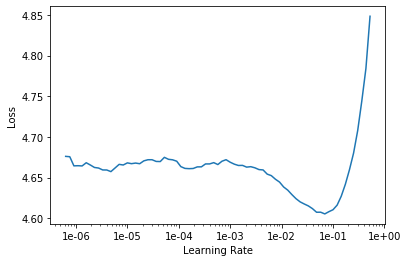

In [9]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [10]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.142146,3.986594,0.297177,17:46


In [11]:
learn.save('resnet34-base-lm-stage_1')

In [12]:
learn.unfreeze()

In [13]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.824148,3.800273,0.317349,20:10
1,3.775747,3.748981,0.325175,20:10
2,3.747183,3.715610,0.329893,20:10
3,3.684536,3.679881,0.334343,20:11
4,3.611908,3.653441,0.337427,20:09
5,3.557941,3.632383,0.339769,20:09
6,3.483032,3.617634,0.341938,20:10
7,3.409786,3.608531,0.343196,20:08
8,3.385752,3.607620,0.343613,20:10
9,3.321783,3.609543,0.343523,20:11


In [14]:
learn.save('resnet34-base-lm-stage_2')

In [15]:
learn.predict('I liked this movie because', 40, temperature=0.75)

"I liked this movie because it did not suck . It was very entertaining and the characters were well developed . The other thing that i liked was that the movie was n't meant to be as racist or racist as it was"

In [16]:
learn.predict('I liked this movie because', 40, temperature=0.75)

"I liked this movie because of the acting . \n \n  The story line is not bad , but the acting is n't very admirable . \n \n  This movie is also a great movie . It shows the magic of Japan in"

In [17]:
learn.save_encoder('resnet34-base_encoder-lm-stage_2')

### Create Classifier

In [5]:
data_cl = (TextList.from_folder(data_dir_path, vocab=data_lm.vocab)
                   .split_by_folder(valid='test')
                   .label_from_folder(classes=['neg', 'pos'])
                   .databunch(bs=16))

In [37]:
data_cl.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj heavy - handed moralism . xxmaj writers using characters as mouthpieces to speak for themselves . xxmaj predictable , plodding plot points ( say that five times fast ) . a child 's imitation of xxmaj britney xxmaj spears . xxmaj this film has all the earmarks of a xxmaj lifetime xxmaj special reject . \n \n i honestly believe that xxmaj jesus xxmaj xxunk and xxmaj",neg
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",pos
"xxbos xxmaj chris xxmaj rock deserves better than he gives himself in "" xxmaj down xxmaj to xxmaj earth . "" xxmaj as directed by brothers xxmaj chris & xxmaj paul xxmaj weitz of "" xxmaj american xxmaj pie "" fame , this uninspired remake of xxmaj warren xxmaj beatty 's 1978 fantasy "" xxmaj heaven xxmaj can xxmaj wait , "" itself a rehash of 1941 's "" xxmaj",neg
"xxbos 8 xxmaj simple xxmaj rules for xxmaj dating xxmaj my xxmaj teenage xxmaj daughter had an auspicious start . xxmaj the supremely - talented xxmaj tom xxmaj shadyac was involved in the project . xxmaj this meant that the comedy would be nothing less of spectacular , and that 's exactly what happened : the show remains one of the freshest , funniest , wittiest shows made in a",pos


In [6]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('resnet34-base_encoder-lm-stage_2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


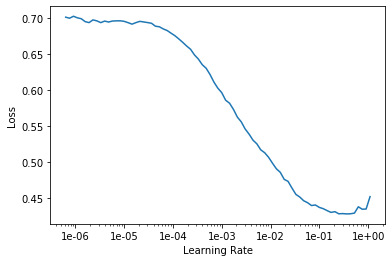

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.258441,0.175501,0.931960,01:57


In [41]:
learn.save('resnet34-base-cl-stage_1')

In [8]:
learn.load('resnet34-base-cl-stage_1');

In [9]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.225816,0.167461,0.937800,02:03


In [10]:
learn.save('resnet34-base-cl-stage_2')

In [7]:
learn.load('resnet34-base-cl-stage_2');

In [8]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.221641,0.146694,0.946760,03:34


In [9]:
learn.save('resnet34-base-cl-stage_3')

In [7]:
learn.load('resnet34-base-cl-stage_3');

In [8]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.190386,0.140571,0.949360,10:41
1,0.193686,0.144667,0.948800,11:15


In [9]:
learn.save('resnet34-base-cl-stage_4')

In [10]:
learn.predict("The movie sucked!!!")

(Category neg, tensor(0), tensor([0.9858, 0.0142]))

In [11]:
learn.predict("The movie was amazing!!!")

(Category pos, tensor(1), tensor([0.0163, 0.9837]))

In [12]:
learn.predict("An absolutely wonderful movie")

(Category pos, tensor(1), tensor([0.0036, 0.9964]))